In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import ast
import cftime

In [2]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    'RCP8.5': ('RCP',2092,'rcp'), 
    'SAI2050': ('SAI',2092,'sai')
}


fname = "RCP.started_2002.001/TCseeds_tracker_results.ref.started_2002.001.nc"

ds = xr.open_dataset(fname, decode_cf=False)

times = ds.TC_tracks.isel(data=0)

v = ds
for i,(desc) in enumerate(v.data.description):
    shortname = desc[:desc.index(':')]
    v[shortname] = v.TC_tracks.isel(data=i).assign_attrs(
        ast.literal_eval(desc[desc.index(':')+1:]))
    v[shortname].data[v[shortname]>1e30] = np.nan
time = v.time.copy()
tmask = np.isnan(time)
time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
v['year'] = time.dt.year.where(~tmask, np.nan)
v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
v['PRECT'].attrs.update({'units':'mm/hour'})
ds = v

Text(1.0, 1.0, 'n = 4690')

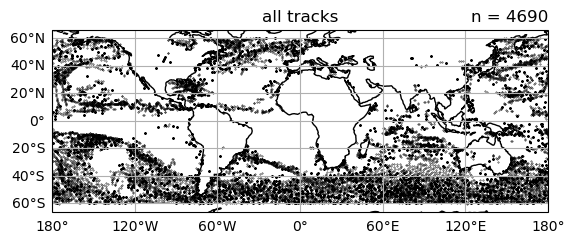

In [3]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(ds.lon, ds.lat, c='k', s=0.1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=['bottom','left'])
ax.set_title(f"all tracks")
ax.set_title(f"n = {ds.id.size}", loc='right')

Text(0.5, 1.0, 'number of tracks')

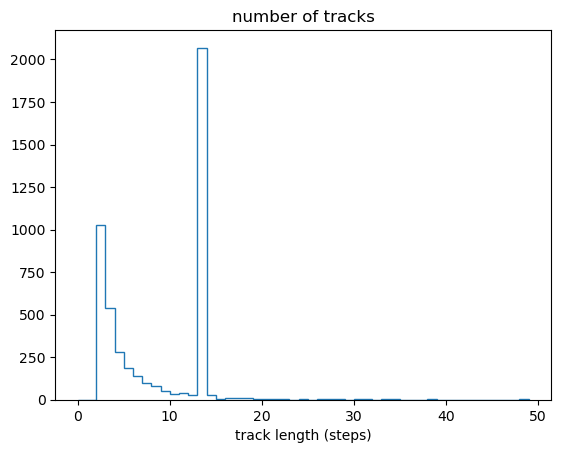

In [4]:
tracksize = ds.lon.notnull().sum('dtime')
hist, bins = np.histogram(tracksize, bins=range(ds.dtime.size+1))
plt.stairs(hist, bins)
plt.xlabel('track length (steps)')
plt.title('number of tracks')

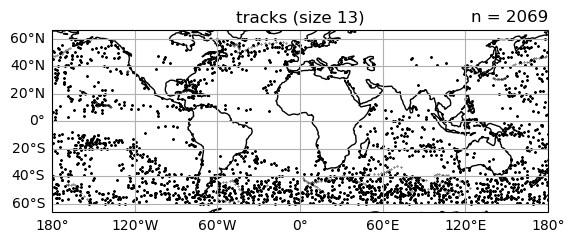

In [6]:
dsi = ds.where(tracksize==13, drop=True)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(dsi.lon, dsi.lat, c='k', s=0.1, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=['bottom','left'])
ax.set_title(f"tracks (size 13)")
_=ax.set_title(f"n = {dsi.id.size}", loc='right')

In [22]:
print(dsi.dtime.size*dsi.id.size)
((dsi.diff('dtime') == 0) | (dsi.diff('dtime').isnull())).sum()

101381


<xarray.Dataset>
Dimensions:    ()
Data variables: (12/16)
    TC_tracks  int64 1261260
    num_days   int64 0
    time       int64 99060
    lon        int64 99076
    lat        int64 99108
    PSL        int64 99060
    ...         ...
    SSTmon     int64 99091
    RV         int64 99060
    Vshear     int64 99060
    PRECT      int64 99060
    TEMP       int64 99060
    year       int64 99312

In [12]:
ds.where(tracksize!=13, drop=True).diff('dtime')

<xarray.Dataset>
Dimensions:    (id: 2621, dtime: 48, data: 13)
Coordinates:
  * id         (id) float64 70.0 72.0 73.0 ... 4.592e+03 4.594e+03 4.596e+03
  * dtime      (dtime) float64 0.125 0.25 0.375 0.5 ... 5.625 5.75 5.875 6.0
  * data       (data) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables: (12/16)
    TC_tracks  (id, dtime, data) float64 0.125 0.3125 -0.2347 ... 0.0 0.0 0.0
    num_days   (id) float64 6.0 6.0 6.0 6.0 6.0 6.0 ... 6.0 6.0 6.0 6.0 6.0 6.0
    time       (id, dtime) float64 0.125 nan nan nan nan ... nan nan nan nan nan
    lon        (id, dtime) float64 0.3125 nan nan nan nan ... nan nan nan nan
    lat        (id, dtime) float64 -0.2347 nan nan nan nan ... nan nan nan nan
    PSL        (id, dtime) float64 1.208 nan nan nan nan ... nan nan nan nan nan
    ...         ...
    SSTmon     (id, dtime) float64 -0.7067 nan nan nan nan ... nan nan nan nan
    RV         (id, dtime) float64 -5.012e-06 nan nan nan ... nan nan nan nan
    Vshear     (id, dtime) float64 -1.999 nan nan nan nan ... nan nan nan nan
    PRECT      (id, dtime) float64 -0.5053 nan nan nan nan ... nan nan nan nan
    TEMP       (id, dtime) float64 -0.145 nan nan nan nan ... nan nan nan nan
    year       (id, dtime) float64 0.0 nan nan nan nan ... nan nan nan nan nan

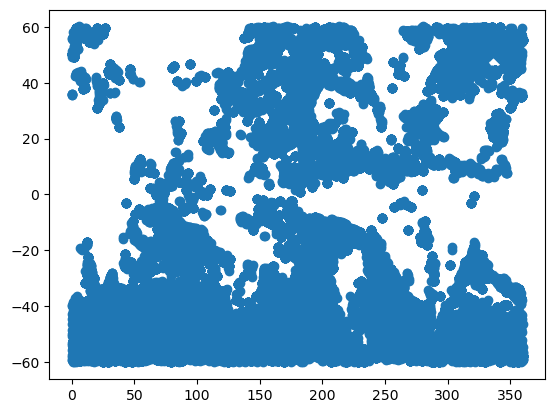

In [25]:
plt.scatter(ds.lon, ds.lat)